# Comprehensive Hearing Research Analysis Pipeline (v3.0)
**Merged Protocol: Vowel, Consonant, and CRM Experiments**

This notebook processes logs from Reiss Lab psychophysics experiments. It integrates data loading, adaptive track analysis, phonetic feature analysis, and statistical hypothesis testing into a static, report-ready format.

### Workflow:
1. **Load Data**: Point to a subject directory.
2. **Assign Conditions**: Batch assign CRM runs to conditions (BM, CI, HA).
3. **Analyze**: Process Vowels, Consonants, and CRM data.
4. **Visualize**: Generate high-density plots and statistical summaries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu
import os
import re
import glob
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

## 1. Helper Functions
Core logic for parsing specific file formats and calculating Speech Reception Thresholds (SRT).

In [2]:
def get_gender(talker_id):
    """0-3 are Male, 4-7 are Female."""
    return 'M' if talker_id <= 3 else 'F'

def parse_crm_header(filepath):
    """Extract talker info from file header."""
    try:
        with open(filepath, 'r') as f:
            header = f.readline()
        match = re.search(r'Talker (\d+), Maskers (\d+) and (\d+)', header)
        if match:
            return int(match.group(1)), int(match.group(2)), int(match.group(3))
    except Exception as e:
        print(f"Header parse error: {e}")
    return None, None, None

def calculate_srt(df_run):
    """Calculates SRT based on reversals 5-14 (or available)."""
    snr_values = df_run['snr'].values
    # Correct if BOTH color and number match
    correct = ((df_run['target_color'] == df_run['response_color']) & 
               (df_run['target_number'] == df_run['response_number'])).values
    
    reversals = []
    prev_correct = correct[0]
    
    for i in range(1, len(correct)):
        if correct[i] != prev_correct:
            reversals.append(snr_values[i])
        prev_correct = correct[i]
    
    if len(reversals) >= 5:
        # Matlab standard: average reversals 5 through end (max 14)
        calc_revs = reversals[4:14] if len(reversals) >= 14 else reversals[4:]
        return np.mean(calc_revs), np.std(calc_revs), len(reversals)
    
    return np.nan, np.nan, len(reversals)

def get_masker_config(talker, m1, m2):
    t_gen = get_gender(talker)
    m_gen = get_gender(m1) # m1 and m2 always same gender in CRM corpus standard
    
    if t_gen == m_gen:
        return "Same Gender", f"{t_gen}-{m_gen}{m_gen}"
    else:
        return "Diff Gender", f"{t_gen}-{m_gen}{m_gen}"

## 2. Data Loading and Condition Assignment
This step scans the folder, loads Vowel/Consonant files automatically, then asks you to categorize the CRM files.

In [3]:
# --- 1. Directory Setup ---
base_path = input("Enter the directory path containing your data files: ").strip()

if not os.path.isdir(base_path):
    raise FileNotFoundError(f"Directory not found: {base_path}")

subject_id = os.path.basename(base_path)
print(f"\nProcessing Subject: {subject_id}")

# --- 2. Load Phonemes (Vowels/Consonants) ---
vowel_cols = ['talker_id', 'vowel_id', 'response_id', 'score', 'rt']
vowel_map = {1:'AE', 2:'AH', 3:'AW', 4:'EH', 5:'IH', 6:'IY', 7:'OO', 8:'UH', 9:'UW'}
cons_cols = ['talker_id', 'consonant_id', 'response_id', 'score', 'rt']
cons_map = {1:'#', 2:'_', 3:'b', 4:'d', 5:'f', 6:'g', 7:'k', 8:'m', 9:'n', 10:'%', 11:'p', 12:'s', 13:'t', 14:'v', 15:'z', 16:'$'}

df_vowel = pd.DataFrame()
df_consonant = pd.DataFrame()

# Attempt to load BM/CI vowel files
try:
    v_bm = pd.read_csv(os.path.join(base_path, f'{subject_id}_vow9_BM_0.txt'), sep='\\s+', header=None, names=vowel_cols)
    v_bm['condition'] = 'BM'
    v_ci = pd.read_csv(os.path.join(base_path, f'{subject_id}_vow9_CI_0.txt'), sep='\\s+', header=None, names=vowel_cols)
    v_ci['condition'] = 'CI'
    df_vowel = pd.concat([v_bm, v_ci], ignore_index=True)
    df_vowel['vowel_label'] = df_vowel['vowel_id'].map(vowel_map)
    df_vowel['response_label'] = df_vowel['response_id'].map(vowel_map)
    print(f"✅ Vowel data loaded ({len(df_vowel)} trials)")
except Exception as e: 
    print(f"⚠️ Vowel load warning: {e}")

# Attempt to load Consonant files
try:
    df_consonant = pd.read_csv(os.path.join(base_path, f'{subject_id}_cons_BM_n_0.out'), sep='\\s+', header=None, names=cons_cols)
    df_consonant['consonant_label'] = df_consonant['consonant_id'].map(cons_map)
    df_consonant['response_label'] = df_consonant['response_id'].map(cons_map)
    print(f"✅ Consonant data loaded ({len(df_consonant)} trials)")
except: 
    print("⚠️ No consonant data found.")

# --- 3. Load and Assign CRM --- 
crm_files_found = sorted([f for f in os.listdir(base_path) if '_crm_' in f and f.endswith('.txt')])

if not crm_files_found:
    print("❌ No CRM files found.")
else:
    # Extract run numbers to display to user
    run_map = {}
    print(f"\nFound {len(crm_files_found)} CRM files. Please assign conditions.")
    print("Available files:")
    for f in crm_files_found:
        # Extract just the run number for simplicity
        run_num = re.search(r'_crm_(\d+)', f).group(1)
        run_map[run_num] = f
        print(f"  Run {run_num}: {f}")
    
    print("\nEnter the RUN NUMBERS for each condition (comma separated, e.g., '1, 2, 3').")
    print("Leave blank if no files belong to that condition.")

    def get_indices(prompt):
        val = input(prompt).strip()
        if not val: return []
        return [x.strip() for x in val.split(',')]

    bm_runs = get_indices("BM Runs: ")
    ci_runs = get_indices("CI Runs: ")
    ha_runs = get_indices("HA Runs: ")

    # Process Files
    crm_data = []
    crm_summary = []

    for run_id, filename in run_map.items():
        condition = 'Unknown'
        if run_id in bm_runs: condition = 'BM'
        elif run_id in ci_runs: condition = 'CI'
        elif run_id in ha_runs: condition = 'HA'
        
        filepath = os.path.join(base_path, filename)
        talker, m1, m2 = parse_crm_header(filepath)
        masker_type, gender_code = get_masker_config(talker, m1, m2)

        try:
            df_temp = pd.read_csv(filepath, sep='\\s+', header=None, skiprows=2, 
                                  names=['run', 'target_color', 'response_color', 'target_number', 'response_number', 'snr', 'rt'], 
                                  on_bad_lines='skip')
            # Cleanup footer
            df_temp = df_temp[pd.to_numeric(df_temp['run'], errors='coerce').notna()].astype(float)
            
            # Calculate SRT
            srt, sd, revs = calculate_srt(df_temp)
            
            # Store Trial Data
            df_temp['filename'] = filename
            df_temp['condition'] = condition
            df_temp['masker_type'] = masker_type
            df_temp['gender_code'] = gender_code
            df_temp['is_correct'] = (df_temp['target_color'] == df_temp['response_color']) & \
                                    (df_temp['target_number'] == df_temp['response_number'])
            crm_data.append(df_temp)
            
            # Store Summary
            crm_summary.append({
                'filename': filename,
                'condition': condition,
                'masker_type': masker_type,
                'gender_code': gender_code,
                'srt': srt,
                'sd': sd,
                'reversals': revs
            })
        except Exception as e:
            print(f"Error reading {filename}: {e}")

    if crm_data:
        df_crm = pd.concat(crm_data, ignore_index=True)
        df_crm_summary = pd.DataFrame(crm_summary)
        print(f"\n✅ Successfully loaded {len(crm_summary)} CRM runs.")
    else:
        df_crm = pd.DataFrame()
        df_crm_summary = pd.DataFrame()

Enter the directory path containing your data files:  /Users/samipkafle/Downloads/reiss_lab_analysis/data/Data/CI148



Processing Subject: CI148
✅ Vowel data loaded (360 trials)
✅ Consonant data loaded (64 trials)

Found 11 CRM files. Please assign conditions.
Available files:
  Run 0: CI148_crm_0.txt
  Run 1: CI148_crm_1.txt
  Run 10: CI148_crm_10.txt
  Run 2: CI148_crm_2.txt
  Run 3: CI148_crm_3.txt
  Run 4: CI148_crm_4.txt
  Run 5: CI148_crm_5.txt
  Run 6: CI148_crm_6.txt
  Run 7: CI148_crm_7.txt
  Run 8: CI148_crm_8.txt
  Run 9: CI148_crm_9.txt

Enter the RUN NUMBERS for each condition (comma separated, e.g., '1, 2, 3').
Leave blank if no files belong to that condition.


BM Runs:  1,2,3,8
CI Runs:  4,6,10
HA Runs:  5,7,9



✅ Successfully loaded 11 CRM runs.


In [4]:
#Path: /Users/samipkafle/Downloads/reiss_lab_analysis/data/Data/CI148

## 3. Phonetic Feature Analysis
This section decomposes errors into feature classes (Voicing, Place, Manner) to understand *why* perception fails.

--- Feature Analysis (n=53) ---
Voicing    98.11
Place      96.23
Manner     94.34
dtype: float64


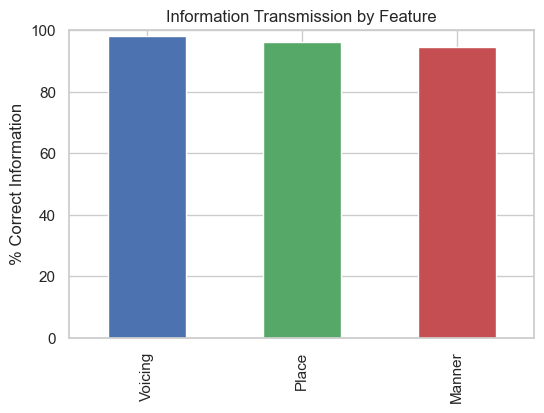

In [5]:
def analyze_features(df, label_col, resp_col):
    # Standard Feature Map: (Voicing, Place, Manner)
    # 0=No/Front/Stop, 1=Yes/Mid/Fric, 2=N/A/Back/Nas
    feature_map = {
        'b': (1, 0, 0), 'd': (1, 1, 0), 'g': (1, 2, 0),
        'p': (0, 0, 0), 't': (0, 1, 0), 'k': (0, 2, 0),
        'm': (1, 0, 2), 'n': (1, 1, 2),
        'f': (0, 0, 1), 'v': (1, 0, 1), 's': (0, 1, 1), 'z': (1, 1, 1),
        '#': (0, 2, 1), '_': (1, 2, 1), # Sh, Zh (approx)
    }
    
    valid = df[df[label_col].isin(feature_map.keys()) & df[resp_col].isin(feature_map.keys())]
    if valid.empty: return

    print(f"--- Feature Analysis (n={len(valid)}) ---")
    
    features = ['Voicing', 'Place', 'Manner']
    stats = {}
    
    for i, feat in enumerate(features):
        t_feat = valid[label_col].apply(lambda x: feature_map[x][i])
        r_feat = valid[resp_col].apply(lambda x: feature_map[x][i])
        correct = (t_feat == r_feat).mean() * 100
        stats[feat] = correct
        
    stats_df = pd.Series(stats)
    print(stats_df.round(2))
    
    # Plot
    plt.figure(figsize=(6, 4))
    stats_df.plot(kind='bar', color=['#4c72b0', '#55a868', '#c44e52'])
    plt.title('Information Transmission by Feature')
    plt.ylabel('% Correct Information')
    plt.ylim(0, 100)
    plt.show()

if not df_consonant.empty:
    analyze_features(df_consonant, 'consonant_label', 'response_label')

## 4. Vowel Confusion Matrix
Visualizing specific vowel confusions to identify spectral smearing or frequency warping issues.

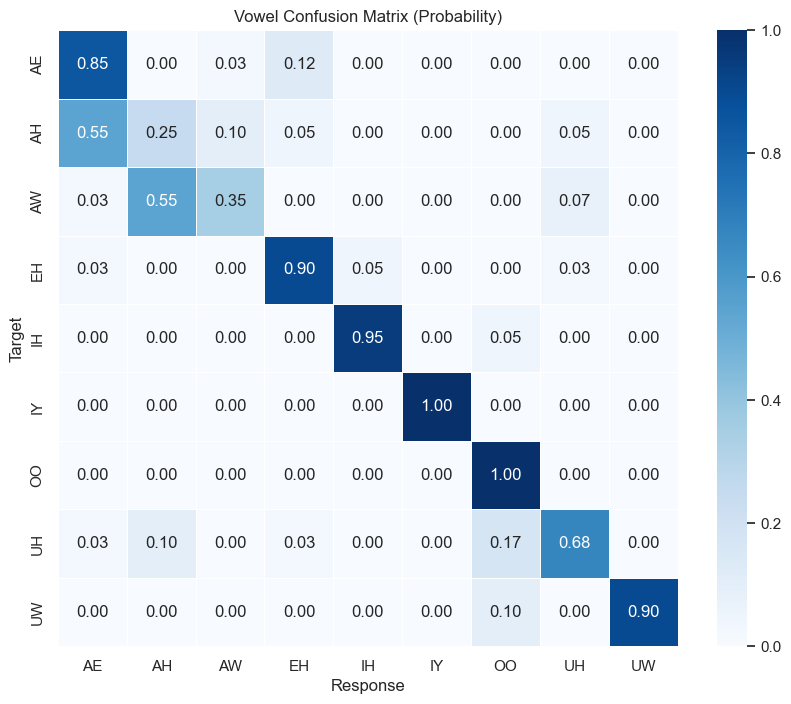

In [6]:
if not df_vowel.empty:
    # Order vowels roughly by formant frequency (Back -> Front or Low -> High)
    vowel_order = ['IY', 'IH', 'EH', 'AE', 'AH', 'UH', 'OO', 'UW', 'AW']
    
    # Filter only labels that exist in data
    present_vowels = sorted(list(set(df_vowel['vowel_label'].unique()) | set(df_vowel['response_label'].unique())))
    
    cm = pd.crosstab(df_vowel['vowel_label'], df_vowel['response_label'])
    # Normalize rows to get probabilities
    cm_prob = cm.div(cm.sum(axis=1), axis=0)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_prob, annot=True, fmt='.2f', cmap='Blues', linewidths=.5)
    plt.title("Vowel Confusion Matrix (Probability)")
    plt.ylabel("Target")
    plt.xlabel("Response")
    plt.show()

## 5. CRM Analysis: SRT and VGRM
Calculates Speech Reception Thresholds and analyzes Voice Gender Release from Masking.

--- SRT Summary by Condition ---
                       mean   std  count
condition masker_type                   
BM        Diff Gender  -1.7  1.84      2
          Same Gender   3.6  0.00      2
CI        Diff Gender   2.1  0.99      2
          Same Gender   2.2   NaN      1
HA        Diff Gender   3.2  0.85      2
          Same Gender   2.6   NaN      1


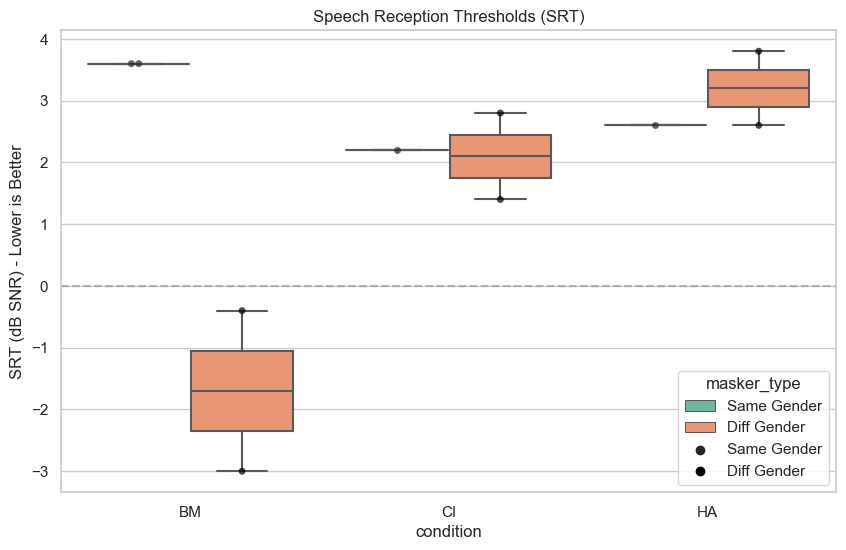


--- Voice Gender Release from Masking (VGRM) ---
BM: 5.30 dB Benefit
CI: 0.10 dB Benefit
HA: -0.60 dB Benefit

--- Specific Gender Config Analysis ---


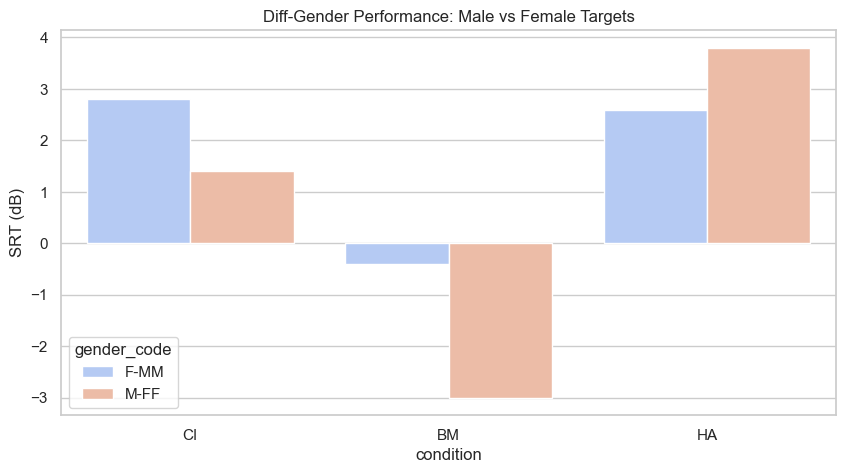

In [7]:
if not df_crm_summary.empty:
    # Remove 'Unknown' for clean stats
    valid_crm = df_crm_summary[df_crm_summary['condition'] != 'Unknown']
    
    print("--- SRT Summary by Condition ---")
    summary_stats = valid_crm.groupby(['condition', 'masker_type'])['srt'].agg(['mean', 'std', 'count']).round(2)
    print(summary_stats)
    
    # 1. Plot SRTs
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='condition', y='srt', hue='masker_type', data=valid_crm, palette='Set2')
    sns.swarmplot(x='condition', y='srt', hue='masker_type', data=valid_crm, dodge=True, color='black', alpha=0.7)
    plt.title('Speech Reception Thresholds (SRT)')
    plt.ylabel('SRT (dB SNR) - Lower is Better')
    plt.axhline(0, linestyle='--', color='gray', alpha=0.5)
    plt.show()
    
    # 2. VGRM Calculation (Same - Diff)
    print("\n--- Voice Gender Release from Masking (VGRM) ---")
    for cond in valid_crm['condition'].unique():
        subset = valid_crm[valid_crm['condition'] == cond]
        same = subset[subset['masker_type'] == 'Same Gender']['srt'].mean()
        diff = subset[subset['masker_type'] == 'Diff Gender']['srt'].mean()
        
        if not np.isnan(same) and not np.isnan(diff):
            vgrm = same - diff
            print(f"{cond}: {vgrm:.2f} dB Benefit")
    
    # 3. Detailed Gender Breakdown (F-MM vs M-FF)
    print("\n--- Specific Gender Config Analysis ---")
    # Filter for Diff Gender only
    diff_gen = valid_crm[valid_crm['masker_type'] == 'Diff Gender']
    
    # Look for patterns like M-FF vs F-MM
    if not diff_gen.empty:
        plt.figure(figsize=(10, 5))
        sns.barplot(x='condition', y='srt', hue='gender_code', data=diff_gen, errorbar='sd', palette='coolwarm')
        plt.title('Diff-Gender Performance: Male vs Female Targets')
        plt.ylabel('SRT (dB)')
        plt.show()

## 6. Statistical Testing
Checking for significant differences between conditions and masker types.

In [8]:
if not df_crm_summary.empty and len(valid_crm) > 2:
    print("--- Statistical Comparisons (T-Tests) ---")
    
    # 1. Same vs Different Gender (Global)
    same_grp = valid_crm[valid_crm['masker_type'] == 'Same Gender']['srt']
    diff_grp = valid_crm[valid_crm['masker_type'] == 'Diff Gender']['srt']
    
    if len(same_grp) > 1 and len(diff_grp) > 1:
        t, p = ttest_ind(same_grp, diff_grp)
        print(f"Global Gender Effect (Same vs Diff): p={p:.4f} {'*' if p<0.05 else ''}")
        if p < 0.05: print("  -> Significant benefit from gender cues.")
        else: print("  -> No significant gender cue benefit detected.")

    # 2. Condition Comparisons (e.g., BM vs CI)
    conditions = valid_crm['condition'].unique()
    import itertools
    for c1, c2 in itertools.combinations(conditions, 2):
        g1 = valid_crm[valid_crm['condition'] == c1]['srt']
        g2 = valid_crm[valid_crm['condition'] == c2]['srt']
        if len(g1) > 1 and len(g2) > 1:
            t, p = ttest_ind(g1, g2)
            print(f"{c1} vs {c2}: p={p:.4f} {'*' if p<0.05 else ''}")

--- Statistical Comparisons (T-Tests) ---
Global Gender Effect (Same vs Diff): p=0.2073 
  -> No significant gender cue benefit detected.
BM vs CI: p=0.5697 
BM vs HA: p=0.3402 
CI vs HA: p=0.2028 


## 7. Exploratory Analysis: Error Types & Temporal Trends
Investigating *how* the subject failed (Color vs Number errors) and if they learned over time.

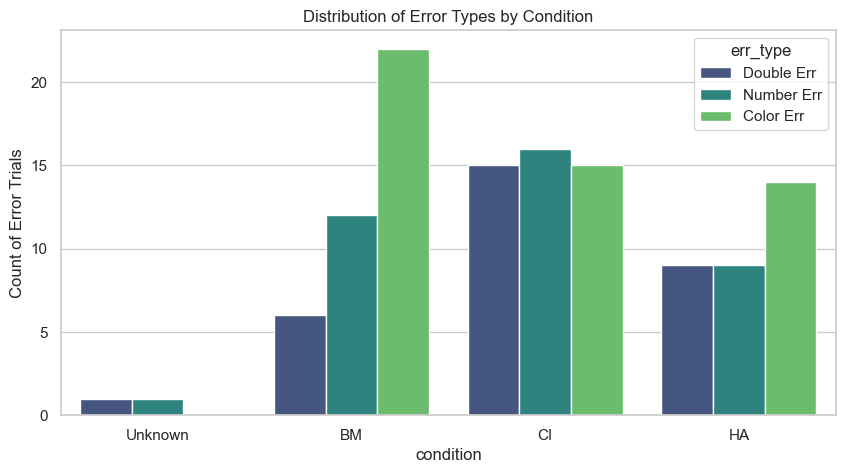

Note: 'Color Err' suggests hearing the carrier phrase but missing the keyword.


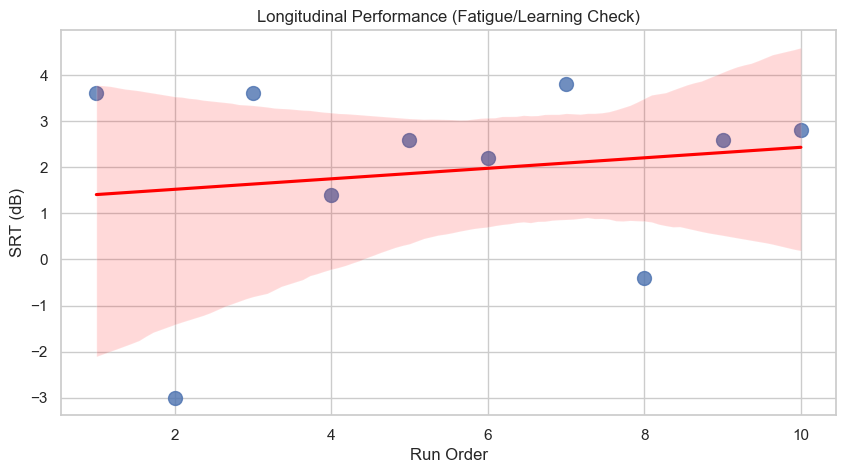

Temporal Trend Slope: 0.114 (p=0.655)
-> Performance stable over time.


In [9]:
if not df_crm.empty:
    # 1. Error Type Breakdown
    def classify_error(row):
        c_ok = row['target_color'] == row['response_color']
        n_ok = row['target_number'] == row['response_number']
        if c_ok and n_ok: return 'Correct'
        if c_ok and not n_ok: return 'Number Err'
        if not c_ok and n_ok: return 'Color Err'
        return 'Double Err'

    df_crm['err_type'] = df_crm.apply(classify_error, axis=1)
    
    # Only look at errors (exclude Correct)
    errors_only = df_crm[df_crm['err_type'] != 'Correct']
    
    if not errors_only.empty:
        plt.figure(figsize=(10, 5))
        sns.countplot(x='condition', hue='err_type', data=errors_only, palette='viridis')
        plt.title('Distribution of Error Types by Condition')
        plt.ylabel('Count of Error Trials')
        plt.show()
        print("Note: 'Color Err' suggests hearing the carrier phrase but missing the keyword.")

    # 2. Temporal Learning (Run Number vs SRT)
    # Extract run index from filename
    valid_crm['run_index'] = valid_crm['filename'].apply(lambda x: int(re.search(r'_crm_(\d+)', x).group(1)))
    valid_crm = valid_crm.sort_values('run_index')
    
    plt.figure(figsize=(10, 5))
    sns.regplot(x='run_index', y='srt', data=valid_crm, scatter_kws={'s':100}, line_kws={'color':'red'})
    plt.title('Longitudinal Performance (Fatigue/Learning Check)')
    plt.xlabel('Run Order')
    plt.ylabel('SRT (dB)')
    plt.show()
    
    slope, intercept, r_val, p_val, std_err = stats.linregress(valid_crm['run_index'], valid_crm['srt'])
    print(f"Temporal Trend Slope: {slope:.3f} (p={p_val:.3f})")
    if slope < -0.1 and p_val < 0.1: print("-> Suggestive of Learning Effect (Performance improving)")
    elif slope > 0.1 and p_val < 0.1: print("-> Suggestive of Fatigue (Performance worsening)")
    else: print("-> Performance stable over time.")

## 8. Grid Visualization of Adaptive Tracks
Plots every CRM run in a grid to visually inspect convergence quality.

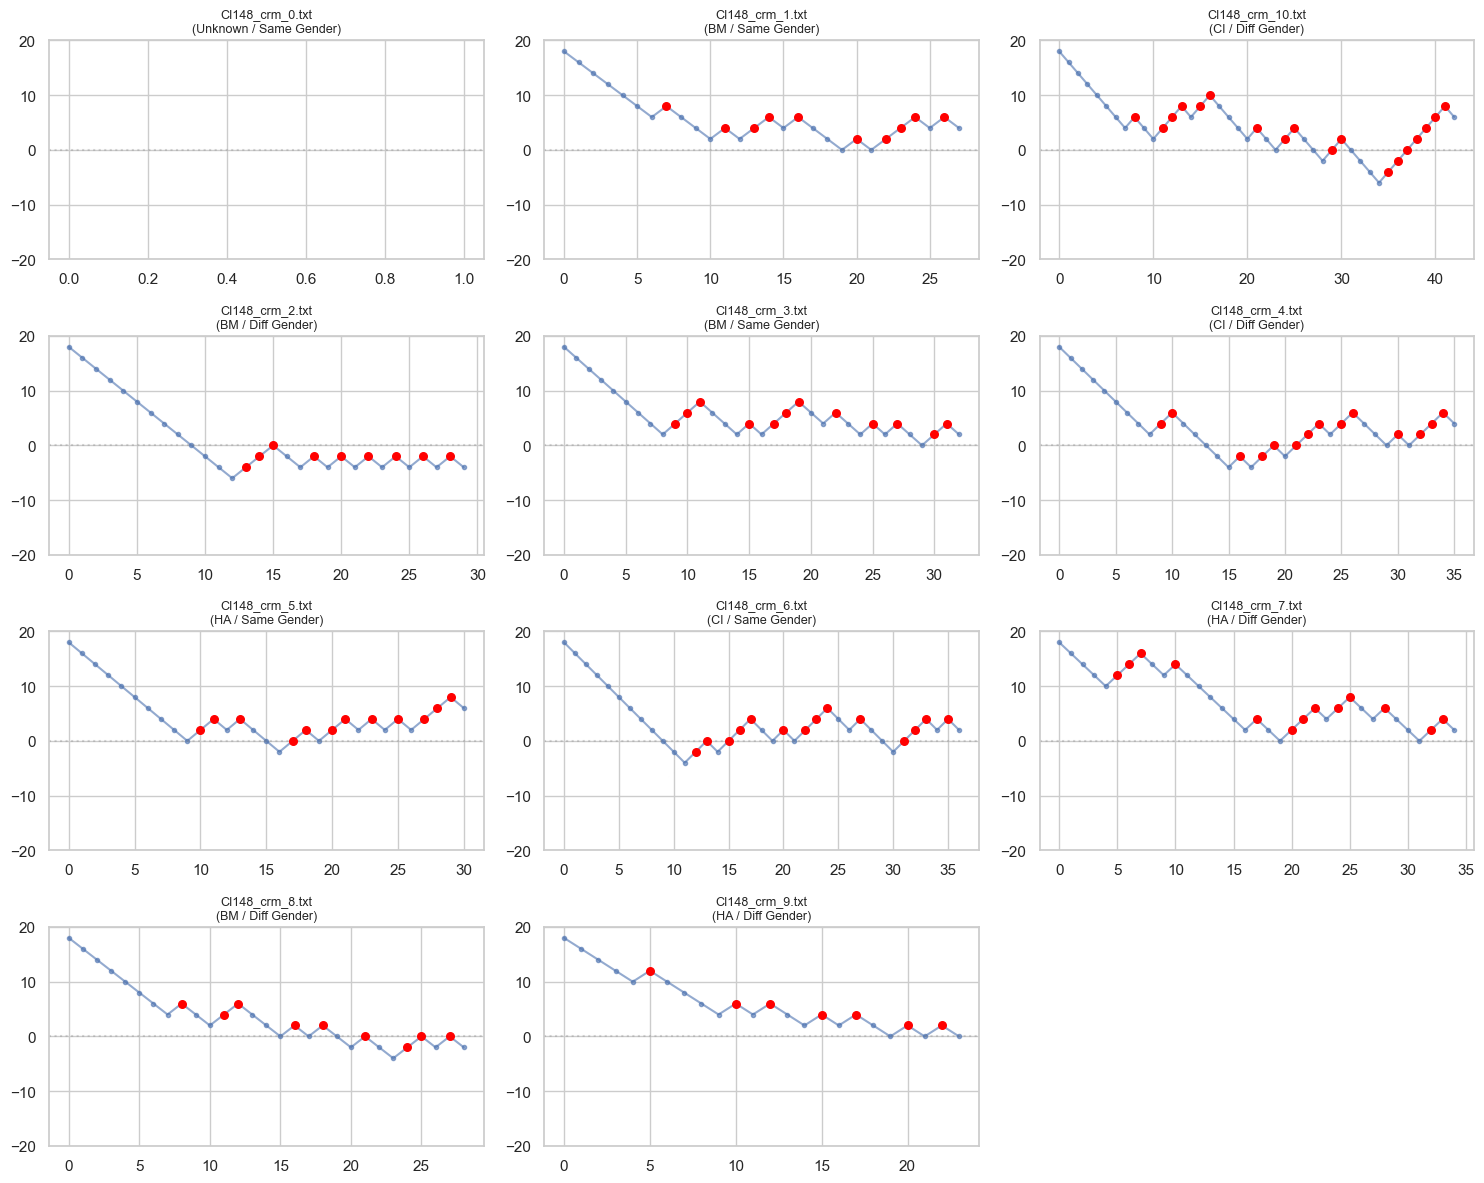

In [10]:
if not df_crm.empty:
    # Get unique files
    files = df_crm['filename'].unique()
    n_files = len(files)
    cols = 3
    rows = int(np.ceil(n_files / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
    axes = axes.flatten()
    
    for i, fname in enumerate(files):
        subset = df_crm[df_crm['filename'] == fname]
        ax = axes[i]
        
        # Plot track
        ax.plot(range(len(subset)), subset['snr'], marker='o', markersize=3, alpha=0.6)
        
        # Highlight errors
        errors = subset[~subset['is_correct']]
        ax.scatter(errors.index - subset.index[0], errors['snr'], color='red', zorder=5, s=30)
        
        # Meta
        cond = subset['condition'].iloc[0]
        mask = subset['masker_type'].iloc[0]
        ax.set_title(f"{fname}\n({cond} / {mask})", fontsize=9)
        ax.set_ylim(-20, 20) # Standard CRM range
        ax.axhline(0, color='gray', alpha=0.3, linestyle=':')
        
    # Hide empty subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.show()